In [158]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Load Raw Data

In [159]:
folder_data = 'gemini/data/'
fn_data = 'tmb_mskcc_2018_clinical_data.tsv'
fp_data = os.path.join(folder_data, fn_data)

In [160]:
raw_data_df = pd.read_csv(fp_data, sep='\t', index_col=1)
print('Number of records:', raw_data_df.shape[0])
raw_data_df.head(4)

Number of records: 1661


,Study ID,Sample ID,Age at Which Sequencing was Reported (Days),Age Group at Diagnosis in Years,Cancer Type,Cancer Type Detailed,Drug Type,Gene Panel,Institute Source,Metastatic Site,...,Overall Survival Status,Primary Tumor Site,Sample Class,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,Somatic Status,TMB Score,Tumor Purity
Patient ID,,,,,,,,,,,,,,,,,,,,,
P-0000057,tmb_mskcc_2018,P-0000057-T01-IM3,41.0,31-50,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,1:DECEASED,Breast,Tumor,1,835,Primary,Female,Matched,5.580000,25
P-0000062,tmb_mskcc_2018,P-0000062-T01-IM3,80.0,>71,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,1:DECEASED,Esophagus,Tumor,1,1176,Primary,Male,Matched,6.691462,30
P-0000063,tmb_mskcc_2018,P-0000063-T01-IM3,62.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,0:LIVING,Bladder,Tumor,1,900,Primary,Male,Matched,16.728656,70
P-0000071,tmb_mskcc_2018,P-0000071-T01-IM3,66.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,0:LIVING,Bladder,Tumor,1,795,Primary,Male,Matched,11.152437,30


## Constructure the time series dataframe and check matrix rank

In [161]:
def construct_ts_matrix(data_df, unit_defined_by=None, filter_by_column=None):
    """Returns a time series matrix for units.
    
    Args:
      data_df: The input dataframe.
      unit_defined_by: A column whose values will be used to group the rows of data_df to form units.
        If None, each row will be one unit.
      filter_by_column: A dict where the keys are column names and values are column values. If given,
        only rows with the matched column values are kept.
    """
    if filter_by_column:
      to_keep = None  
      for k,v in filter_by_column.items():
        if to_keep is None:
          to_keep = (data_df[k] == v)
        else:
          to_keep = (filter_flags & (data_df[k] == v))
      data_df = data_df[to_keep]
    
    # Next, besides survival data, we only keep the column used to define units.
    data_df = data_df[[unit_defined_by, KEY_SURVIVAL_MONTH]]
    
    units = sorted(list(set(data_df[unit_defined_by])))
    survival_df = pd.DataFrame(index=units, columns=[KEY_SURVIVAL_MONTH]) 
    for u in units:
      survival_df.at[u, KEY_SURVIVAL_MONTH] = np.mean(
          data_df[data_df[unit_defined_by]==u][KEY_SURVIVAL_MONTH])
    
    max_survival_mo = int(np.floor(np.max(survival_df[KEY_SURVIVAL_MONTH])))
    print('max_survival_mo', max_survival_mo)
    ts_df = pd.DataFrame(index=values_for_grouping,
                         columns=range(max_survival_mo))
    for i in units:
      survival_month_rounded = int(np.floor(survival_df.at[i, KEY_SURVIVAL_MONTH]))
      ts_df.at[i,:] = [1.0]*(survival_month_rounded) + [0]*(max_survival_mo - survival_month_rounded)
    return ts_df, survival_df


def plot_spectrum(ts_df):
  ts_array = ts_df.to_numpy().astype(np.float)
  (U, s, Vh) = np.linalg.svd((ts_array) - np.mean(ts_array))
  s2 = np.power(s, 2)
  spectrum = np.cumsum(s2)/np.sum(s2)

  plt.plot(spectrum)
  plt.grid()
  plt.title("Cumulative energy")
  plt.figure()
  plt.plot(s2)
  plt.grid()
  plt.xlabel("Ordered Singular Values") 
  plt.ylabel("Energy")
  plt.title("Singular Value Spectrum")


def analyze_ts_matrix_rank(drug_type):
  ts_df, survival_df = construct_ts_matrix(
      data_df,
      unit_defined_by=KEY_CANCER_TYPE,
      filter_by_column={KEY_DRUG_TYPE:drug_type})
  print(survival_df)
  print(ts_df)
  plot_spectrum(ts_df)

In [162]:
KEY_SURVIVAL_MONTH = 'Overall Survival (Months)'
KEY_CANCER_TYPE = 'Cancer Type'
KEY_DRUG_TYPE = 'Drug Type'
KEY_PATIENT_ID = 'Patient ID'

data_df = raw_data_df[[KEY_CANCER_TYPE, KEY_DRUG_TYPE, KEY_SURVIVAL_MONTH]]
data_df.head(4)

,Cancer Type,Drug Type,Overall Survival (Months)
Patient ID,,,
P-0000057,Breast Cancer,PD-1/PDL-1,0
P-0000062,Esophagogastric Cancer,PD-1/PDL-1,1
P-0000063,Bladder Cancer,PD-1/PDL-1,42
P-0000071,Bladder Cancer,PD-1/PDL-1,43


max_survival_mo 22
                           Overall Survival (Months)
Bladder Cancer                               10.8698
Breast Cancer                                    7.4
Cancer of Unknown Primary                    6.67105
Colorectal Cancer                            11.5859
Esophagogastric Cancer                       7.54839
Glioma                                       11.6842
Head and Neck Cancer                         9.87786
Melanoma                                        16.1
Non-Small Cell Lung Cancer                   11.6383
Renal Cell Carcinoma                         22.3689
Skin Cancer, Non-Melanoma                          2
                           0  1  2  3  4  5  6  7  8  9   ... 12 13 14 15 16  \
Bladder Cancer              1  1  1  1  1  1  1  1  1  1  ...  0  0  0  0  0   
Breast Cancer               1  1  1  1  1  1  1  0  0  0  ...  0  0  0  0  0   
Cancer of Unknown Primary   1  1  1  1  1  1  0  0  0  0  ...  0  0  0  0  0   
Colorectal Cancer        

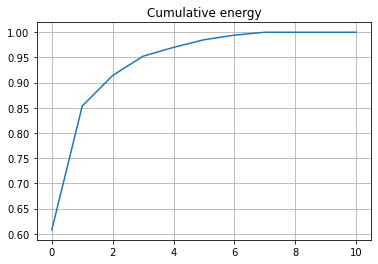

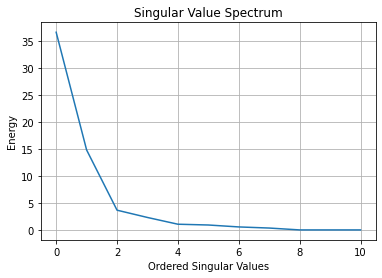

In [163]:
analyze_ts_matrix_rank('PD-1/PDL-1')

max_survival_mo 33
                          Overall Survival (Months)
Breast Cancer                                 11.65
Cancer of Unknown Primary                         2
Colorectal Cancer                                 4
Esophagogastric Cancer                           11
Melanoma                                    33.7333
                          0  1  2  3  4  5  6  7  8  9   ... 23 24 25 26 27  \
Breast Cancer              1  1  1  1  1  1  1  1  1  1  ...  0  0  0  0  0   
Cancer of Unknown Primary  1  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
Colorectal Cancer          1  1  1  1  0  0  0  0  0  0  ...  0  0  0  0  0   
Esophagogastric Cancer     1  1  1  1  1  1  1  1  1  1  ...  0  0  0  0  0   
Melanoma                   1  1  1  1  1  1  1  1  1  1  ...  1  1  1  1  1   

                          28 29 30 31 32  
Breast Cancer              0  0  0  0  0  
Cancer of Unknown Primary  0  0  0  0  0  
Colorectal Cancer          0  0  0  0  0  
Esophagogastric Cancer

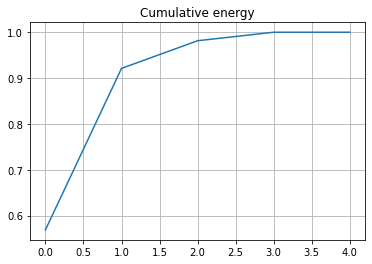

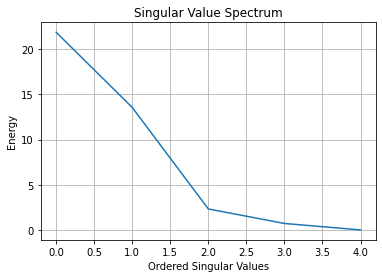

In [164]:
analyze_ts_matrix_rank('CTLA4')

max_survival_mo 29
                           Overall Survival (Months)
Bladder Cancer                               16.8261
Breast Cancer                                     10
Cancer of Unknown Primary                    5.90909
Colorectal Cancer                                6.9
Esophagogastric Cancer                       7.29032
Glioma                                            18
Head and Neck Cancer                          10.125
Melanoma                                     20.5565
Non-Small Cell Lung Cancer                   27.8571
Renal Cell Carcinoma                         29.3793
                           0  1  2  3  4  5  6  7  8  9   ... 19 20 21 22 23  \
Bladder Cancer              1  1  1  1  1  1  1  1  1  1  ...  0  0  0  0  0   
Breast Cancer               1  1  1  1  1  1  1  1  1  1  ...  0  0  0  0  0   
Cancer of Unknown Primary   1  1  1  1  1  0  0  0  0  0  ...  0  0  0  0  0   
Colorectal Cancer           1  1  1  1  1  1  0  0  0  0  ...  0  0  0  0  0  

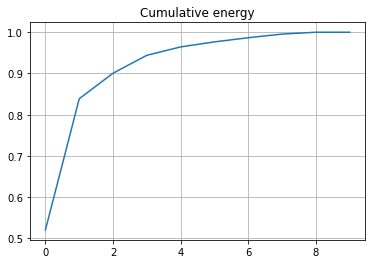

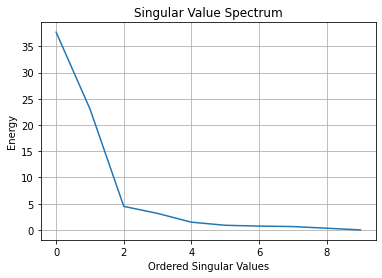

In [165]:
analyze_ts_matrix_rank('Combo')